In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
from PIL import Image
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
def plt_show_image(image):
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [3]:
pipe.scheduler.init_noise_sigma

NameError: name 'pipe' is not defined

In [4]:
@torch.no_grad()
def generate_simplified(
        prompt=['a beautiful girl'],
        uncond_prompt=[''],
        num_inference_steps=50,
        guidance_scale=7.5,
        # do_classifier_free_guidance=True,
        batch_size=1,
        height=512,
        width=512,
        generator=None
):
    #Get the text embeddings
    text_inputs = pipe.tokenizer(
        prompt,
        #用的就是stable diffusion的tokenizer  
        padding='max_length',
        max_length=pipe.tokenizer.model_max_length,
        return_tensors='pt',  #pytorch,其他可选的还有 tf,np
    )
    #拿到indexes,,,然后放入text_Encoder里得到text_embeddings
    text_inputs_ids = text_inputs.input_ids
    text_embeddings = pipe.text_encoder(text_inputs_ids.to(pipe.device))[0]
    bs_embed, seq_len, _ = text_embeddings.shape

    #get the negative prompt text embeddings
    max_length = text_inputs_ids.shape[-1]
    uncond_input = pipe.tokenizer(
        uncond_prompt,
        padding='max_length',
        max_length=max_length,
        truncation=True,  #过长时截断
        return_tensors='pt',
    )
    uncond_embeddings = pipe.text_encoder(uncond_input.input_ids.to(pipe.device))[0]
    #经过上述操作就拿到了一对 text_embeddings+uncond_text_embeddings
    #当有多个prompt时,,,每一对中的 text_embedding不同,但是uncond_text_embedding相同
    seq_len = uncond_input.input_ids.shape[1]
    uncond_embeddings = uncond_embeddings.repeat(batch_size, 1, 1)
    uncond_embeddings = uncond_embeddings.view(batch_size, seq_len, -1)
    #TODO:为什么nagetive_prompt和unconditional_embeddings是相同的?

    #concat
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    #噪声要是8的倍数
    latents_shape = (batch_size, pipe.unet.in_channels, height // 8, width // 8)
    latents_dtype = text_embeddings.dtype
    latents = torch.randn(
        latents_shape,
        generator=generator,
        device=pipe.device,
        dtype=latents_dtype
    )
    #set timesteps
    pipe.scheduler.set_timesteps(num_inference_steps)
    timesteps_tensor = pipe.scheduler.timesteps.to(pipe.device)

    latents = latents * pipe.scheduler.init_noise_sigma

    #main diffusion process 采样循环
    for i, t in enumerate(pipe.progress_bar(timesteps_tensor)):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

        #predict the noise residual->预测噪声残差(余量,注意这里不是整个噪声)
        #三个参数,循环的latent_model_input,时间步t,text_embeddings
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        #perform guidance->classifier free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        #uncond - guidance_scale * uncond + guidance_scale * cond

        #calculate the previous noisy sample x_t -> x_t-1
        latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

    #循环结束后进入 Variational Autoencoder Decoder -> 得到图片
    latents = latents / 0.18215
    image = pipe.vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)  #限制到0~1

    image = image.cpu().permute(0, 2, 3, 1).float().numpy()
    return image

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/data_disk/dyy/miniconda3/envs/Wz/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_1937041/309110987.py:47: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents_shape = (batch_size, pipe.unet.in_channels, height // 8, width // 8)


  0%|          | 0/50 [00:00<?, ?it/s]

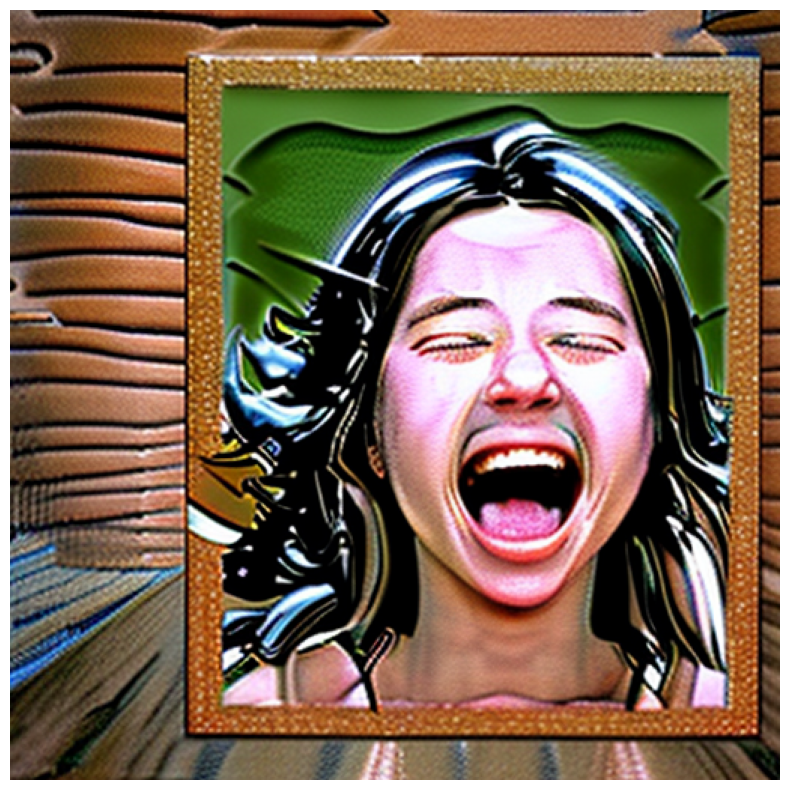

In [5]:
if __name__ == "__main__":
    pipe = StableDiffusionPipeline.from_pretrained(
        "/data_disk/dyy/stable-diffusion-2",
        revision='fp16',
        torch_dtype=torch.float16
    ).to(device)

    image = generate_simplified(
        prompt=['laughing girl'],
    )
    plt_show_image(image[0])